In [250]:
import requests, json
import pandas as pd
import numpy as np
%matplotlib inline
SESSION = requests.Session()
f = open("bs_node_ip.txt","r")
RPC_HOST = f.readline()
RPC_HOST = str.replace(RPC_HOST,'\n','')
RPC_PORT = '8545'
RPC_URL = 'http://'+RPC_HOST+':'+RPC_PORT

## Basic JSON downloading

In [140]:
def getJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    response = json.loads(json_data)
    return response

In [141]:
def getRawJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    return json_data

In [142]:
# test if the getJSON function supports GET requests
# getJSON('https://api.etherscan.io/api?module=account&action=balance&address=0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae&tag=latest&apikey=YourApiKeyToken')

In [143]:
# test if the getJSON function supports POST requests
# getJSON(RPC_URL,'{"jsonrpc":"2.0","method":"eth_syncing","params":[],"id":1}')

## Consensys EthJsonRpc Package

I wasn't able to quickly make the package work on Python 3

In [144]:
# from ethjsonrpc import EthJsonRpc
# c = EthJsonRpc('35.196.250.157', 8545)
# print(c.net_version())
# print(c.web3_clientVersion())
# print(c.eth_gasPrice())

So I began copying their functions. Most of them still need testing. Ideally we should fork and make our own package compatible with Python 3

In [145]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def hex_to_dec(x):
    '''
    Convert hex to decimal
    '''
    return int(x, 16)

In [146]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def clean_hex(d):
    '''
    Convert decimal to hex and remove the "L" suffix that is appended to large
    numbers
    '''
    return hex(d).rstrip('L')

In [147]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def validate_block(block):
#     doesn't work on Python 3
#     if isinstance(block, basestring):
#         if block not in BLOCK_TAGS:
#             raise ValueError('invalid block tag')
    if isinstance(block, int):
        block = hex(block)
    return block

In [148]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def wei_to_ether(wei):
    '''
    Convert wei to ether
    '''
    return 1.0 * wei / 10**18

In [149]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def ether_to_wei(ether):
    '''
    Convert ether to wei
    '''
    return ether * 10**18

In [150]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/exceptions.py
class EthJsonRpcError(Exception):
    pass
class ConnectionError(EthJsonRpcError):
    pass
class BadStatusCodeError(EthJsonRpcError):
    pass
class BadJsonError(EthJsonRpcError):
    pass
class BadResponseError(EthJsonRpcError):
    pass

In [151]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
BLOCK_TAG_EARLIEST = 'earliest'
BLOCK_TAG_LATEST   = 'latest'
BLOCK_TAG_PENDING  = 'pending'
BLOCK_TAGS = (
    BLOCK_TAG_EARLIEST,
    BLOCK_TAG_LATEST,
    BLOCK_TAG_PENDING,
)

In [152]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def _call(method, params=None, _id=1):
    params = params or []
    data = {
        'jsonrpc': '2.0',
        'method':  method,
        'params':  params,
        'id':      _id,
    }
    scheme = 'http'
#     if tls:
#         scheme += 's'
    url = '{}://{}:{}'.format(scheme, RPC_HOST, RPC_PORT)
    headers = {'Content-Type': 'application/json'}
    try:
        r = SESSION.post(url, headers=headers, data=json.dumps(data))
    except RequestsConnectionError:
        raise ConnectionError
    if r.status_code / 100 != 2:
        raise BadStatusCodeError(r.status_code)
    try:
        response = r.json()
    except ValueError:
        raise BadJsonError(r.text)
    try:
        return response['result']
    except KeyError:
        raise BadResponseError(response)

In [153]:
################################################################################
# high-level methods
################################################################################

In [154]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def transfer(from_, to, amount):
    '''
    Send wei from one address to another
    '''
    return eth_sendTransaction(from_address=from_, to_address=to, value=amount)

In [155]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def create_contract(from_, code, gas, sig=None, args=None):
    '''
    Create a contract on the blockchain from compiled EVM code. Returns the
    transaction hash.
    '''
    from_ = from_ or eth_coinbase()
    if sig is not None and args is not None:
         types = sig[sig.find('(') + 1: sig.find(')')].split(',')
         encoded_params = encode_abi(types, args)
         code += encoded_params.encode('hex')
    return eth_sendTransaction(from_address=from_, gas=gas, data=code)

In [156]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def get_contract_address(tx):
    '''
    Get the address for a contract from the transaction that created it
    '''
    receipt = eth_getTransactionReceipt(tx)
    return receipt['contractAddress']

In [157]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call(address, sig, args, result_types):
    '''
    Call a contract function on the RPC server, without sending a
    transaction (useful for reading data)
    '''
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    response = eth_call(to_address=address, data=data_hex)
    return decode_abi(result_types, response[2:].decode('hex'))

In [158]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call_with_transaction(from_, address, sig, args, gas=None, gas_price=None, value=None):
    '''
    Call a contract function by sending a transaction (useful for storing
    data)
    '''
    gas = gas or DEFAULT_GAS_PER_TX
    gas_price = gas_price or DEFAULT_GAS_PRICE
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    return eth_sendTransaction(from_address=from_, to_address=address, data=data_hex, gas=gas,
                                    gas_price=gas_price, value=value)

In [159]:
################################################################################
# JSON-RPC methods
################################################################################

In [160]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_clientVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_clientversion
    NEEDS TESTING
    '''
    return _call('web3_clientVersion')

In [161]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_sha3(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_sha3
    NEEDS TESTING
    '''
    data = str(data).encode('hex')
    return _call('web3_sha3', [data])

In [162]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_version
    NEEDS TESTING
    '''
    return _call('net_version')

In [163]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_listening():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_listening
    NEEDS TESTING
    '''
    return _call('net_listening')

In [164]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_peerCount():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_peercount
    NEEDS TESTING
    '''
    return hex_to_dec(_call('net_peerCount'))

In [165]:
def eth_protocolVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_protocolversion
    NEEDS TESTING
    '''
    return _call('eth_protocolVersion')

In [166]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_syncing():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_syncing
    TESTED - MARKUS 2018-02-07
    '''
    return _call('eth_syncing')

In [167]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_coinbase():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_coinbase
    NEEDS TESTING
    '''
    return _call('eth_coinbase')

In [168]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_mining():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_mining
    NEEDS TESTING
    '''
    return _call('eth_mining')

In [169]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_hashrate():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_hashrate
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_hashrate'))

In [170]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_gasPrice():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gasprice
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_gasPrice'))

In [171]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_accounts():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_accounts
    NEEDS TESTING
    '''
    return _call('eth_accounts')

In [172]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_blockNumber():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_blocknumber
    TESTED - MARKUS 2018-02-07
    '''
    return hex_to_dec(_call('eth_blockNumber'))

In [173]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBalance(address=None, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getbalance
    TESTED - MARKUS 2018-02-07
    '''
    address = address or eth_coinbase()
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBalance', [address, block]))

In [174]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getStorageAt(address=None, position=0, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getstorageat
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getStorageAt', [address, hex(position), block])

In [175]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionCount(address, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactioncount
    TESTED - MARKUS 2018-02-07
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getTransactionCount', [address, block]))

In [176]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbyhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getBlockTransactionCountByHash', [block_hash]))

In [177]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBlockTransactionCountByNumber', [block]))

In [178]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblockhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getUncleCountByBlockHash', [block_hash]))

In [179]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblocknumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getUncleCountByBlockNumber', [block]))

In [180]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCode(address, default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcode
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    return _call('eth_getCode', [address, default_block])

In [181]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sign(address, data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sign
    NEEDS TESTING
    '''
    return _call('eth_sign', [address, data])

In [182]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendTransaction(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                        nonce=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendtransaction
    NEEDS TESTING
    '''
    params = {}
    params['from'] = from_address or eth_coinbase()
    if to_address is not None:
        params['to'] = to_address
    if gas is not None:
        params['gas'] = hex(gas)
    if gas_price is not None:
        params['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        params['value'] = clean_hex(value)
    if data is not None:
        params['data'] = data
    if nonce is not None:
        params['nonce'] = hex(nonce)
    return _call('eth_sendTransaction', [params])

In [183]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendRawTransaction(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendrawtransaction
    NEEDS TESTING
    '''
    return _call('eth_sendRawTransaction', [data])

In [184]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_call(to_address, from_address=None, gas=None, gas_price=None, value=None, data=None,
             default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_call
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return _call('eth_call', [obj, default_block])

In [185]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_estimateGas(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                    default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_estimategas
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    if to_address is not None:
        obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return hex_to_dec(_call('eth_estimateGas', [obj, default_block]))

In [186]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByHash(block_hash, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbyhash
    NEEDS TESTING
    '''
    return _call('eth_getBlockByHash', [block_hash, tx_objects])

In [187]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByNumber(block=BLOCK_TAG_LATEST, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getBlockByNumber', [block, tx_objects])

In [188]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByHash(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyhash
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByHash', [tx_hash])

In [189]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByBlockHashAndIndex', [block_hash, hex(index)])

In [190]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getTransactionByBlockNumberAndIndex', [block, hex(index)])

In [191]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionReceipt(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionreceipt
    NEEDS TESTING
    '''
    return _call('eth_getTransactionReceipt', [tx_hash])

In [192]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getUncleByBlockHashAndIndex', [block_hash, hex(index)])

In [193]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getUncleByBlockNumberAndIndex', [block, hex(index)])

In [194]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCompilers():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcompilers
    NEEDS TESTING
    '''
    return _call('eth_getCompilers')

In [195]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSolidity(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilesolidity
    NEEDS TESTING
    '''
    return _call('eth_compileSolidity', [code])

In [196]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileLLL(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilelll
    N/A
    '''
    return _call('eth_compileLLL', [code])

In [197]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSerpent(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compileserpent
    N/A
    '''
    return _call('eth_compileSerpent', [code])

In [198]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newFilter(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_newFilter', [_filter])

In [199]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newBlockFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newblockfilter
    NEEDS TESTING
    '''
    return _call('eth_newBlockFilter')

In [200]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newPendingTransactionFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newpendingtransactionfilter
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_newPendingTransactionFilter'))

In [201]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_uninstallfilter
    NEEDS TESTING
    '''
    return _call('eth_uninstallFilter', [filter_id])

In [202]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterchanges
    NEEDS TESTING
    '''
    return _call('eth_getFilterChanges', [filter_id])

In [203]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterLogs(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterlogs
    NEEDS TESTING
    '''
    return _call('eth_getFilterLogs', [filter_id])

In [204]:
#FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
#def eth_getLogs(filter_object):
#    return _call('eth_getLogs', [filter_object])

# redefined by Markus 2018-02-08
def eth_getLogs(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getlogs
    TESTED - MARKUS 2018-02-08
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_getLogs', [_filter])

In [205]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getWork():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getwork
    NEEDS TESTING
    '''
    return _call('eth_getWork')

In [206]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitWork(nonce, header, mix_digest):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submitwork
    NEEDS TESTING
    '''
    return _call('eth_submitWork', [nonce, header, mix_digest])

In [207]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitHashrate(hash_rate, client_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submithashrate
    NEEDS TESTING
    '''
    return _call('eth_submitHashrate', [hex(hash_rate), client_id])

In [208]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_version
    N/A
    '''
    return _call('shh_version')

In [209]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_post(topics, payload, priority, ttl, from_=None, to=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_post
    NEEDS TESTING
    '''
    whisper_object = {
        'from':     from_,
        'to':       to,
        'topics':   topics,
        'payload':  payload,
        'priority': hex(priority),
        'ttl':      hex(ttl),
    }
    return _call('shh_post', [whisper_object])

In [210]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newIdentity():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newidentity
    N/A
    '''
    return _call('shh_newIdentity')

In [211]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_hasIdentity(address):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_hasidentity
    NEEDS TESTING
    '''
    return _call('shh_hasIdentity', [address])

In [212]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newgroup
    N/A
    '''
    return _call('shh_newGroup')

In [213]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_addToGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_addtogroup
    NEEDS TESTING
    '''
    return _call('shh_addToGroup')

In [214]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newFilter(to, topics):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'to':     to,
        'topics': topics,
    }
    return _call('shh_newFilter', [_filter])

In [215]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_uninstallfilter
    NEEDS TESTING
    '''
    return _call('shh_uninstallFilter', [filter_id])

In [216]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getfilterchanges
    NEEDS TESTING
    '''
    return _call('shh_getFilterChanges', [filter_id])

In [217]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getMessages(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getmessages
    NEEDS TESTING
    '''
    return _call('shh_getMessages', [filter_id])    

# Crypto Kitties Explorer
Exploring CryptoKitties data using JSON RPC on the BlockScience geth node

In [322]:
# define the addresses of the relevant contracts
coreContract = '0x06012c8cf97bead5deae237070f9587f8e7a266d'
contracts = {
    coreContract : 'core',
    '0xc7af99fe5513eb6710e6d5f44f9989da40f27f26' : 'siringAuction',
    '0xb1690c08e213a35ed9bab7b318de14420fb57d8c' : 'saleAuction',
}

# relevant Events signatures
events_signatures = {
    'AuctionCreated' : 'AuctionCreated(uint256,uint256,uint256,uint256)', # AuctionCreated(uint256 tokenId, uint256 startingPrice, uint256 endingPrice, uint256 duration);
    'AuctionSuccessful' : 'AuctionSuccessful(uint256,uint256,address)', # AuctionSuccessful(uint256 tokenId, uint256 totalPrice, address winner);
    'AuctionCancelled' : 'AuctionCancelled(uint256)', # AuctionCancelled(uint256 tokenId);
    'Pause' : 'Pause()',
    'Unpause' : 'Unpause()',
    'Transfer' : 'Transfer(address,address,uint256)', # Transfer(address from, address to, uint256 tokenId);
    'Approval' : 'Approval(address,address,uint256)', # Approval(address owner, address approved, uint256 tokenId);
    'ContractUpgrade' : 'ContractUpgrade(address)',
    'Birth' : 'Birth(address,uint256,uint256,uint256,uint256)', # Birth(address owner, uint256 kittyId, uint256 matronId, uint256 sireId, uint256 genes);
    'Pregnant' : 'Pregnant(address,uint256,uint256,uint256)' # Pregnant(address owner, uint256 matronId, uint256 sireId, uint256 cooldownEndBlock);
}

from Crypto.Hash import keccak
def keccak256(string):
    return keccak.new(digest_bits=256, data=bytes(string, 'utf-8')).hexdigest()

events_hashes = {'0x'+keccak256(v): k for k, v in events_signatures.items()}

In [249]:
for event in events_signatures:
    print(event + ': ' + keccak256(events_signatures[event]))

AuctionCreated: a9c8dfcda5664a5a124c713e386da27de87432d5b668e79458501eb296389ba7
AuctionSuccessful: 4fcc30d90a842164dd58501ab874a101a3749c3d4747139cefe7c876f4ccebd2
AuctionCancelled: 2809c7e17bf978fbc7194c0a694b638c4215e9140cacc6c38ca36010b45697df
Pause: 6985a02210a168e66602d3235cb6db0e70f92b3ba4d376a33c0f3d9434bff625
Unpause: 7805862f689e2f13df9f062ff482ad3ad112aca9e0847911ed832e158c525b33
Transfer: ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef
Approval: 8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925
ContractUpgrade: 450db8da6efbe9c22f2347f7c2021231df1fc58d3ae9a2fa75d39fa446199305
Birth: 0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5
Pregnant: 241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80


In [297]:
def getEvents(_address, _from_block, _to_block):
    json = eth_getLogs(from_block=_from_block, 
                       to_block=_to_block,
                       address=_address)
    df = pd.DataFrame.from_dict(json)
    df['contract'] = df['address'].apply(lambda x: contracts[x])
    df['event'] = df['topics'].apply(lambda x: events_hashes[x[0]])
    return df

from_block = hex(eth_blockNumber() - 200)
to_block = hex(eth_blockNumber())

events = None

for c in contracts:
    if events is None:
        events = getEvents(c, from_block, to_block)
    else:
        e = getEvents(c, from_block, to_block)
        events = events.append(e, ignore_index=True)
events.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event
0,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x00000000000000000000000024a6f141b18f27f65a1b...,0x7,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204...,0xaae5be6ae718d3af38388bcf8a65ba1072ed56c765f2...,0x6,core,Birth
1,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x00000000000000000000000000000000000000000000...,0x8,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xaae5be6ae718d3af38388bcf8a65ba1072ed56c765f2...,0x6,core,Transfer
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x0000000000000000000000001f2e6c8a1f3062da4bd6...,0x1b,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Birth
3,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x00000000000000000000000000000000000000000000...,0x1c,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Transfer
4,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x00000000000000000000000024a6f141b18f27f65a1b...,0x1d,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Birth


In [298]:
events[['contract','event']].drop_duplicates()

,contract,event
0,core,Birth
1,core,Transfer
20,core,Pregnant
485,core,Approval
1163,siringAuction,AuctionSuccessful
1169,siringAuction,AuctionCreated
1184,siringAuction,AuctionCancelled
1217,saleAuction,AuctionCreated
1218,saleAuction,AuctionSuccessful
1227,saleAuction,AuctionCancelled


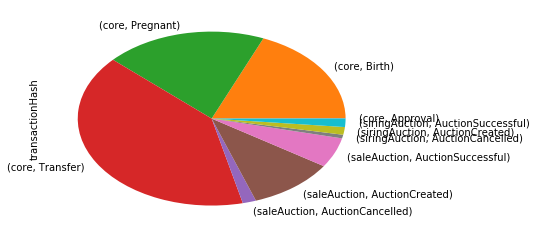

In [306]:
events.groupby(['contract','event']).transactionHash.count().plot(kind='pie')

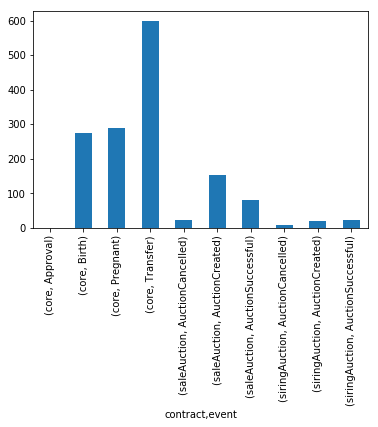

In [305]:
events.groupby(['contract','event']).transactionHash.count().plot(kind='bar')

In [300]:
events.sort_values(['blockNumber', 'transactionIndex', 'logIndex']).head(20)

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x0000000000000000000000001f2e6c8a1f3062da4bd6...,0x1b,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Birth
3,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x00000000000000000000000000000000000000000000...,0x1c,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Transfer
4,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x00000000000000000000000024a6f141b18f27f65a1b...,0x1d,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Birth
5,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x00000000000000000000000000000000000000000000...,0x1e,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Transfer
6,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x0000000000000000000000002f73e080e34d3dbf6a0c...,0x1f,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Birth
7,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x00000000000000000000000000000000000000000000...,0x20,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Transfer
8,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x000000000000000000000000d70e1fe62ac070b2c821...,0x21,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Birth
9,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x00000000000000000000000000000000000000000000...,0x22,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Transfer
10,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x000000000000000000000000e60a1d508ae6f4e59209...,0x23,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Birth
11,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x72560762680d419e8f9ceb86141c681c097a739e90a3...,0x4e9410,0x00000000000000000000000000000000000000000000...,0x24,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab455...,0x2b,core,Transfer


In [307]:
events.sort_values(['blockNumber', 'transactionIndex', 'logIndex']).head(20).transactionHash.loc[2]

'0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab4555aac3c6da59dc09d62e0'

In [308]:
events.sort_values(['blockNumber', 'transactionIndex', 'logIndex']).head(20).transactionHash.loc[15]

'0x58a5d848c63a0ced69c671eff4d6decb01ae57bfa8dd315ac1a758e5aa192e6e'

## Strange transactions: lots of births and transfers

0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab4555aac3c6da59dc09d62e0
0x58a5d848c63a0ced69c671eff4d6decb01ae57bfa8dd315ac1a758e5aa192e6e

Looks like a smart contract (0xF8Fb76B05fd854cc6f35d5088B9D241CbbF616C3) that calls giveBirth on all pregnant kitties whose gestation period has passed

## Most wanted genes
We can get the genetic sequence of the most recent breeds to try to see what the most wanted genes are

In [310]:
pregnancies = events[events['event'] == 'Pregnant']
pregnancies.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event
20,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x699ad7b68abf754c847b6fdb9f9ebc331f674b23e442...,0x4e9411,0x00000000000000000000000035e2268306aab43014da...,0x98,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xf328e3da021c51943dcff39d1a31d9ecee572ce9091e...,0x54,core,Pregnant
30,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000f5eeecc91a6e05ef5e02...,0x1d,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x8416b9d1fd2e98ce6bad98afcb06a91a27b62b12b48b...,0x32,core,Pregnant
31,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000ef658c8cea1244a46d42...,0x23,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x44a0107e7e5efe286eb6325b628fe0615b819cf55c4d...,0x39,core,Pregnant
32,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000e1e7ba7f42a262069b8f...,0x26,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x660363490295bead9d59a5d18ff0038fdd43519705be...,0x3c,core,Pregnant
33,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000cf3e677e859021f26992...,0x3f,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x1d6005986252292d33b4b3d3ce6cdfffebade1a57c0a...,0x43,core,Pregnant


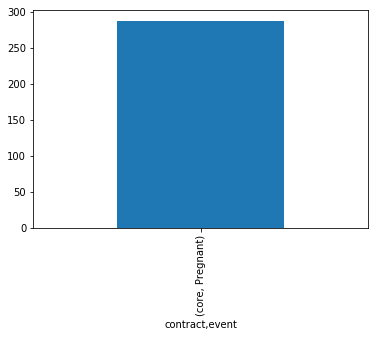

In [311]:
pregnancies.groupby(['contract','event']).transactionHash.count().plot(kind='bar')

In [312]:
pregnancies.data.loc[20]

'0x00000000000000000000000035e2268306aab43014da143f110431ec0140957a00000000000000000000000000000000000000000000000000000000000834c5000000000000000000000000000000000000000000000000000000000008514600000000000000000000000000000000000000000000000000000000004e9439'

The data field of a Pregnant should be structured as such:
1. '0x'
1. '000000000000000000000000' - 24 zeros before the owner address
1. owner address (40 hex characters)
1. matronId (64 hex characters)
1. sireId (64 hex characters)
1. cooldownEndBlock (64 hex characters)

In [321]:
pregnancies['owner'] = '0x' + pregnancies['data'].apply(lambda x: x[26:66])
pregnancies['matronId'] = pregnancies['data'].apply(lambda x: x[66:130])
pregnancies['sireId'] = pregnancies['data'].apply(lambda x: x[130:194])
pregnancies['matronId_dec'] = pregnancies['data'].apply(lambda x: int(x[66:130],16))
pregnancies['sireId_dec'] = pregnancies['data'].apply(lambda x: int(x[130:194],16))
pregnancies.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event,owner,matronId,sireId,matronId_dec,sireId_dec
20,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x699ad7b68abf754c847b6fdb9f9ebc331f674b23e442...,0x4e9411,0x00000000000000000000000035e2268306aab43014da...,0x98,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xf328e3da021c51943dcff39d1a31d9ecee572ce9091e...,0x54,core,Pregnant,0x35e2268306aab43014da143f110431ec0140957a,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,537797,545094
30,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000f5eeecc91a6e05ef5e02...,0x1d,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x8416b9d1fd2e98ce6bad98afcb06a91a27b62b12b48b...,0x32,core,Pregnant,0xf5eeecc91a6e05ef5e0224211aeedb4dd94e559e,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,476878,540577
31,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000ef658c8cea1244a46d42...,0x23,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x44a0107e7e5efe286eb6325b628fe0615b819cf55c4d...,0x39,core,Pregnant,0xef658c8cea1244a46d42adb60052d71014d66aef,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,544965,543046
32,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000e1e7ba7f42a262069b8f...,0x26,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x660363490295bead9d59a5d18ff0038fdd43519705be...,0x3c,core,Pregnant,0xe1e7ba7f42a262069b8f296be7cbf9bff96f4ad8,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,541102,543040
33,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000cf3e677e859021f26992...,0x3f,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x1d6005986252292d33b4b3d3ce6cdfffebade1a57c0a...,0x43,core,Pregnant,0xcf3e677e859021f26992f49aeb54446c97345ca2,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,545077,542620


In [330]:
def getKittyGenes(kittyId):
    kitty = eth_call(to_address=coreContract, data='0xe98b7f4d'+kittyId)
    return kitty[-64:]

pregnancies['matronGenes'] = pregnancies['matronId'].apply(lambda x: '0x'+getKittyGenes(x))
pregnancies['sireGenes'] = pregnancies['sireId'].apply(lambda x: '0x'+getKittyGenes(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [331]:
pregnancies.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event,owner,matronId,sireId,matronId_dec,sireId_dec,matronGenes,sireGenes
20,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x699ad7b68abf754c847b6fdb9f9ebc331f674b23e442...,0x4e9411,0x00000000000000000000000035e2268306aab43014da...,0x98,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xf328e3da021c51943dcff39d1a31d9ecee572ce9091e...,0x54,core,Pregnant,0x35e2268306aab43014da143f110431ec0140957a,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,537797,545094,0x000042d69214251a5ce5ad206006031d4042dcd195e0...,0x00006316c390e60b8ce4b93718005330c66184c390ca...
30,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000f5eeecc91a6e05ef5e02...,0x1d,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x8416b9d1fd2e98ce6bad98afcb06a91a27b62b12b48b...,0x32,core,Pregnant,0xf5eeecc91a6e05ef5e0224211aeedb4dd94e559e,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,476878,540577,0x000042129394e6099234a5cb615911b0c67314602944...,0x000042d14294213182e5bc4263185305415898e201e5...
31,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000ef658c8cea1244a46d42...,0x23,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x44a0107e7e5efe286eb6325b628fe0615b819cf55c4d...,0x39,core,Pregnant,0xef658c8cea1244a46d42adb60052d71014d66aef,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,544965,543046,0x00006268b210810a42900d6818ca57182062dcc3a943...,0x000062d0b390243242e7b86b118e53b0c62b8c851cc3...
32,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000e1e7ba7f42a262069b8f...,0x26,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x660363490295bead9d59a5d18ff0038fdd43519705be...,0x3c,core,Pregnant,0xe1e7ba7f42a262069b8f296be7cbf9bff96f4ad8,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,541102,543040,0x00006316831ce7184c158c0a2823171c6e498c839940...,0x00004252831ce6304c940c1a330b138941335aa2b945...
33,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe614057fa690ec5c96f83b096356de5a3155c433a62a...,0x4e9413,0x000000000000000000000000cf3e677e859021f26992...,0x3f,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x1d6005986252292d33b4b3d3ce6cdfffebade1a57c0a...,0x43,core,Pregnant,0xcf3e677e859021f26992f49aeb54446c97345ca2,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,545077,542620,0x00004a128398847246e7a41729c0539841634cb50645...,0x000042d6c314e5704c940ef76140511c875a16d0a8a5...


Next: split genes into cattributes (is that how it works?) and plot histograms